# 🎥 GDP-06 모든 장르 간 편향성 측정해보기 


- 이번 시간에는 임베딩 안의 편향성을 확인 해 보고, 이를 WEAT(Word Embedding Association Test) 방식을 이용해 임베딩 모델의 편향을 측정 해 보고, 영화 시놉시스 코퍼스를 이용해 영화 구분과 영화 장르 간에 내재된 편향성을 측정해 보았습니다.
- 이번 프로젝트에선 모든 영화 장르에 대해 영화  구분과의 편향성 정도를 측정해 봅니다. 


----
\\

# 루브릭 평가 기준 

| 평가문항 | 상세기준 |
| --- | --- |
| 1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다. | 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다. |
| 2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다. | 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다. |
| 3. WEAT score 계산 및 시각화를 정상적으로 진행하였다. | 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다. |


----
\\

# 목차

## 1. 데이터 및 라이브러리 불러오기 
## 2. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 언어를 추출하기
## 3. 추출된 결과로 embedding model 만들기
## 4. TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
## 후기
## 🖇 참고 페이지 

----
\\

# 1. 데이터 및 라이브러리 불러오기 


* 프로젝트에 진행에 필요한 라이브러리와 데이터를 가져옵니다. 

* target, attribute 단어 셋 만들기에 필요한 시놉시스 데이터를 가져옵니다.

* gensim 등 필요한 패키지를 설치 한 다음, 불러와 줍니다.


In [62]:
# 폰트 설치 - 폰트 깨졌을 때! 
# 폰트 설치 후, 런타임 재시작 해야 안깨짐 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [63]:
# konlpy 설치 
!pip install konlpy

In [64]:
# 필요한 라이브러리 및 모듈 불러오기

import pandas as pd
import numpy as np
import seaborn as sns
import os, gensim, sklearn, konlpy

# 2. 형태소 분석기로 명사인 단어 추출 
from konlpy.tag import Okt

# 3. 추출된 결과로 embedding model 만들기
from gensim.models import Word2Vec

# 4. TF/IDF로 단어 셋 만들기
from sklearn.feature_extraction.text import TfidfVectorizer

# 5. WEAT score 계산하기
from numpy import dot
from numpy.linalg import norm

# 6. 시각화
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [65]:
# 각 라이브러리의 버전 확인하기 
print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(sns.__version__)

0.6.0
3.6.0
1.0.2
0.11.2


In [66]:
# 글꼴 설정 확인
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

Python 3.7.13
설정 폰트 글꼴: ['NanumBarunGothic'], 설정 폰트 사이즈: 12.0


In [67]:
# synopsis 폴더로 이동 
os.chdir('/content/drive/MyDrive/AIFFEL/mkdir/weat/synopsis')

* 코랩의 gensim 버전은 3.x 버전이기 때문에, 4.X 버전 기준으로 작성된 LMS 노드의 코드를 가져올 땐 꼭 오류가 발생하지 않는지 확인 해야합니다. 

* 데이터셋이 있는 폴더로 작업 환경을 이동합니다. 
* 제대로 연결 되었는지, 다섯 문장을 추출 해 읽어와보겠습니다.

In [68]:
# 데이터셋에 있는 폴더로 이동했기 때문에, 긴 경로를 작성할 필요가 없습니다. 
with open('synopsis.txt', 'r') as file:
    for i in range(5):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.


----
\\

# 2. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 언어를 추출하기 


* synopsis.txt 파일의 데이터를 konlpy 패키지를 이용해 품사가 명사인 경우만 남겨 tokenized
라는 변수명으로 저장 해 봅니다. 

In [69]:
# tokenized 변수에 저장 
okt = Okt()
tokenized = []
with open('synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ['Noun']:
                res.append(w[0]) # 명사일 때만 tokenized에 저장 
        tokenized.append(res)

print('tokenized 변수에 저장~~')

tokenized 변수에 저장~~


In [70]:
# tokenized의 데이터 수 
print(len(tokenized))

71156


In [71]:
# tokenized 의 type 확인 
print(type(tokenized))

<class 'list'>


In [72]:
# 5개만 불러와서 확인 해봅니다. 
tokenized[:5]

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤']]

----
\\

# 3. 추출 된 결과로 Embedding Model 만들기 


* 2번에서 추출한 `tokenize` 에 담긴 데이터를 가지고 Word2Vec을 생성합니다. 

* 잘 훈련 되었는지도 확인 해 봅니다.

In [73]:
# Embedding Model 생성하기 
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('작품', 0.8987511992454529),
 ('다큐멘터리', 0.8540351986885071),
 ('드라마', 0.823577344417572),
 ('영화로', 0.8163931965827942),
 ('형식', 0.8151457905769348),
 ('코미디', 0.8006949424743652),
 ('주제', 0.791531503200531),
 ('스토리', 0.7834060788154602),
 ('편의', 0.7816134691238403),
 ('소재', 0.7803533673286438)]

* Word2Vec 모델 학습에 사용된 하이퍼 파라미터 

    - `sentences` : 각 문장 마다 하나의 토큰 list를 생성하며 토큰 list의 개수는 문장 개수 n개 만큼 생성하여 sentences에 저장해둠
    - `size` : word 벡터 차원
    - `window` : 현재 단어와 예측 단어의 최대 거리
    - `min_count` : min_count의 빈도수보다 낮은 빈도수인 단어는 무시합니다.
    - `sg` : sg 값이 1이면 skip-gram이지만 그렇지 않으면 CBOW 알고리즘을 이용합니다.



In [74]:
# 다른 단어를 입력해, 학습이 잘 되었는지 확인 해 봅니다.
model.wv.most_similar(positive=['지구'])

[('우주', 0.9403133988380432),
 ('인류', 0.9311428070068359),
 ('행성', 0.9195505380630493),
 ('외계', 0.8754429817199707),
 ('파괴', 0.8747604489326477),
 ('지배', 0.8665487766265869),
 ('재앙', 0.8623397350311279),
 ('물리', 0.8585426211357117),
 ('멸망', 0.8522101044654846),
 ('평화', 0.8513023853302002)]

In [75]:
model.wv.most_similar(positive=['조폭'])

[('털이범', 0.9705249071121216),
 ('폭주족', 0.9700404405593872),
 ('소매치기', 0.967260479927063),
 ('지명', 0.9669005870819092),
 ('콕스', 0.9651473760604858),
 ('폭력배', 0.9646561741828918),
 ('회계사', 0.9632391333580017),
 ('냉혈', 0.962638258934021),
 ('주조', 0.962540864944458),
 ('스트리퍼', 0.9625027179718018)]

In [76]:
model.wv.most_similar(positive=['풀잎'])

[('재미나', 0.8681221604347229),
 ('반딧불', 0.860020101070404),
 ('맑은', 0.8478657007217407),
 ('눈사람', 0.8460125923156738),
 ('실업계', 0.8448861837387085),
 ('육중', 0.8393086194992065),
 ('노을', 0.8388099074363708),
 ('다문화', 0.8373083472251892),
 ('허황', 0.8353900909423828),
 ('눈높이', 0.8349448442459106)]

* 관련있는 단어를 잘 찾아낸 것 같다! 
* 영화의 장르와 관련 있을 법한 단어의 유사 단어는 잘 찾아내는 반면, 관련이 없어보이는 단어는 영화와 관련있는 단어보다 유사도도 낮고, 관련 없어보이는 단어들도 몇몇 보인다. 

----
\\

# 4. TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기


* WEAT score를 구할 때 필요한 단어 셋을 만들어 줍니다. 
    - targets_X, targets_Y, attribute_A, attribute_B
- 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할 지 정합니다.
- 여기선 영화 장르, 영화 구분 정보를 두 축으로 이용합니다.
    - 영화 구분 정보 : 일반영화, 예술영화, 독립영화로 구분된 정보 
    KOBIS에서 제공한 정보를 기준으로 분류.

In [77]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [78]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [79]:
print(type(art), type(gen))
print(len(art), len(gen))

<class 'str'> <class 'str'>
620208 3014815


### TF-IDF 사용

- 단어 분석에 TF-IDF를 사용합니다.
- 코퍼스에서 자주 나타는(TF가 높은) 단어지만, 다른 코퍼스에까지 두루 걸쳐 나오지 않는(IDF 가 높은! ) 단어를 선정하기 위해서!

In [80]:
#TF-IDF로 벡터화! 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [81]:

print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [82]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

- 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출합니다.

In [83]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [84]:
len(w1_), len(w2_)

(100, 100)

In [85]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [86]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [87]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [88]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [89]:
len(genre)

21

In [90]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [91]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse = True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end =': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=',')
        j += 1
    attributes.append(attr)
    print()

SF: 위해,자신,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


지구,시작,사람,인류,인간,미래,우주,그녀,로봇,세계,모든,박사,우주선,
가족: 엄마,아빠,가족,영화제,자신,위해,친구,아주르,아버지,시작,그녀,아들,마을,국제,낙타,
공연: 오페라,사랑,토스카,실황,올레,자신,카바,그녀,공연,오텔로,리골레토,백작,프레,베르디,위해,
공포(호러): 시작,위해,사람,자신,친구,그녀,사건,공포,발견,죽음,마을,가족,악령,남자,좀비,
기타: 영화제,국제,서울,단편,영화,자신,사람,이야기,그녀,남자,위해,시작,사랑,뉴미디어,페스티벌,
다큐멘터리: 영화제,영화,다큐,국제,다큐멘터리,사람,이야기,대한,자신,감독,위해,서울,우리,시작,세계,
드라마: 자신,영화제,그녀,사람,사랑,영화,위해,시작,국제,남자,친구,이야기,엄마,여자,아버지,
멜로로맨스: 그녀,사랑,자신,시작,남편,남자,여자,사람,친구,섹스,위해,마음,결혼,서로,아내,
뮤지컬: 뮤지컬,사랑,에스메랄다,그녀,음악,충무로,모차르트,영화,토스카,자신,니웨,카바,영화제,바흐,페뷔스,
미스터리: 사건,그녀,시작,자신,위해,사람,발견,사고,진실,죽음,기억,살인,친구,아내,남자,
범죄: 사건,위해,자신,경찰,시작,그녀,범죄,조직,살인,사람,마약,형사,남자,모든,살해,
사극: 조선,위해,시작,신기전,사랑,자신,아가멤논,황제,그녀,루안,최고,운명,사람,하선,전쟁,
서부극(웨스턴): 서부,보안관,위해,벌린,카우보이,그레이프바인,헨리,마을,자신,개릿,아이,시작,무법자,프린트,마적,
성인물(에로): 그녀,남편,마사지,자신,섹스,관계,영화,정사,남자,위해,시작,여자,유부녀,마음,사랑,
스릴러: 자신,그녀,사건,시작,위해,사람,살인,남자,발견,아내,경찰,친구,모든,사실,살해,
애니메이션: 애니메이션,국제,영화제,친구,인디애니페스트,위해,자신,시작,사람,페스티벌,서울,이야기,아이,마을,소녀,
액션: 위해,자신,시작,조직,사건,사람,그녀,경찰,전쟁,모든,목숨,사실,친구,가족,요원,
어드벤처: 위해,자신,시작,친구,마을,아버지,영화,아이,사람,여행,세계,앤트,세상,가족,모험,
전쟁: 전쟁,독일군,전투,위해,작

----
\\

# 5. WEAT score 계산하기 


* 영화 시놉시스 데이터셋을 계산해 보기 전에, 예제에 있던 내용을 가지고 먼저 계산 연습을 해 보겠습니다. 
    * 단어 셋을 정의하고, WEAT score를 계산하여 평균값까지 계산하여 연관성을 알아봅니다.


## &nbsp;&nbsp; 5-1 예제로 알아보는 WEAT Score 계산법

1. target, attribute 단어 셋 정의 하기

- 단어 셋을 정할 때는 두 개의 target 셋의 크기가 같아야 하고, 두 개의 attribute 셋의 크기가 같아야 합니다.
    - targets
        - X set(꽃) : 장미, 튤립, 백합, 데이지
        - Y set(곤충) : 거미, 모기, 파리, 메뚜기
    - attributes
        - A set(유쾌) : 사랑, 행복, 웃음
        - B set(불쾌) : 재난, 고통, 증오

In [92]:
# 위 단어의 임베딩 결과 가 아래와 같다 했을때, 
target_X = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3.0, -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
target_Y = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

attribute_A = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
attribute_B = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}

In [93]:
# 각 셋들을 A, B, X, Y 라는 변수에 numpy 배열로 할당 
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])

In [94]:
# 잘 들어갔는지 확인! 
print(X)
print(Y)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [95]:
# 잘 들어갔는지 확인! (2)
print(A)
print(B)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [96]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis = -1)
    mean_b = np.mean(c_b, axis = -1)
    return mean_A - mean_b


In [97]:
# target x 에 있는 '장미' 란 단어가 attribute A, B 중에 어디에 더 가까울까요?
# 제시한 단어가 A에 가깝다면 양수, B에 가깝다면 음수? 
print(s(target_X['사랑'], A, B))

0.5901751654626237


In [98]:
print(s(target_Y['재난'], A, B))

-0.6691842929755343


2. 두 attribute의 평균 값 알아보기


- target_X와 attribute_A, attribute_B 사의의 평균값, 그리고 target_Y와 attribute_A, attribute_B 사의의 평균값은 어떻게 될까요?

In [99]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.37181942 0.41632807 0.21117431]
0.333


In [100]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.39609272 -0.37389852 -0.41242037]
-0.394


* WEAT score 계산 함수 생성


In [101]:
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return (mean_X-mean_Y) / std_dev

print(round(weat_score(X, Y, A, B), 3))

1.97


* 시각화

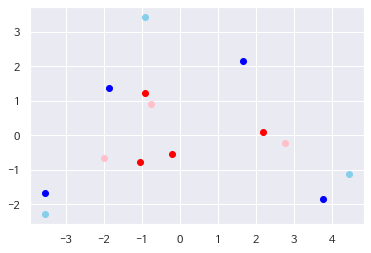

In [102]:
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')


- WEAT score가 매우 높게 나온 것을 알 수 있습니다. 즉, 꽃은 유쾌한 단어와 상대적으로 가깝고, 곤충은 불쾌한 단어와 가깝다는 것을 수치적으로 확인할 수 있었습니다.


## &nbsp;&nbsp; 5-2 시놉시스 데이터셋 WEAT Score 계산하기 

In [103]:
# 구현결과를 담을 21x21 matrix
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [104]:
# target이 될 예술영화와 일반영화의 임베딩 결과를 각각 A, B에 할당. 
A = np.array([model.wv[word] for word in target_art]) # 예술영화
B = np.array([model.wv[word] for word in target_gen]) # 일반영화 

# Attribute 는 만들어둔 영화 장르에서 유연하게 선택 가능. 
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [121]:
# WEAT Score를 출력해 볼까나! 
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        # score가 1.1보다 크거나, -1.1보다 작은경우 출력합니다. 
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i],genre_name[j],matrix[i][j])

SF 멜로로맨스 -1.3503379
공포(호러) 다큐멘터리 1.2175647
기타 멜로로맨스 -1.1930088
다큐멘터리 멜로로맨스 -1.5001531
다큐멘터리 미스터리 -1.3323402
다큐멘터리 성인물(에로) -1.2638773
다큐멘터리 스릴러 -1.2259527
멜로로맨스 범죄 1.2146842
멜로로맨스 서부극(웨스턴) 1.1775393
멜로로맨스 애니메이션 1.177749
멜로로맨스 액션 1.1020045
멜로로맨스 전쟁 1.4624602
미스터리 전쟁 1.18296


### 결과 해석!

* 예제의 WEAT Score를 해석으로 봤을 때,
    - A = 예술영화, B = 일반영화 
    - score가 양수일 경우 왼쪽에 있는 값이 A에 가깝고, 오른쪽에 있는게 B와 가깝다 라고 해석 했었던것 같다. 

* 이를 위 내용을 토대로 결과를 해석 해 본다면,

| index | Weat score | 예술영화 | 일반영화 |
| --- | --- | --- | --- |
| 1 | 음 | 멜로로맨스 | SF |
| 2 | 양 | 공포(호러) | 다큐멘터리 |
| 3 | 음 | 기타 | 멜로로맨스 |
| 4 | 음 | 멜로로맨스 | 다큐멘터리 |
| 5 | 음 | 미스터리 | 다큐멘터리 |
| 6 | 음 | 성인물(애로) | 다큐멘터리 |
| 7 | 음 | 스릴러 | 다큐멘터리 |
| 8 | 양 | 멜로로맨스 | 범죄 |
| 9 | 양 | 멜로로맨스 | 서부극(웨스턴) |
| 10 | 양 | 멜로로맨스 | 애니메이션 |
| 11 | 양 | 멜로로맨스 | 액션 |
| 12 | 양 | 멜로로맨스 | 전쟁 |
| 13 | 양 | 미스터리 | 전쟁 |

* 멜로로맨스가 예술영화와 가깝고, 다큐멘터리가 일반영화와 가깝다고 할 수 있겠다. 

----
\\

# 6. 시각화 

* 5번에서 구한 WEAT Score를 가지고 Heatmap을 그려봅니다. 
* 한국어 지원 폰트가 없으면, 그래프 출력 시 범례 글자가 깨져서 출력되기 때문에 꼭 한국어 지원 폰트로 바꿔주어야 한다. 
* 코랩의 경우, 폰트를 지정해 준 다음, 런타임 다시시작을 해 줘야 정상적으로 폰트가 반영된다. 

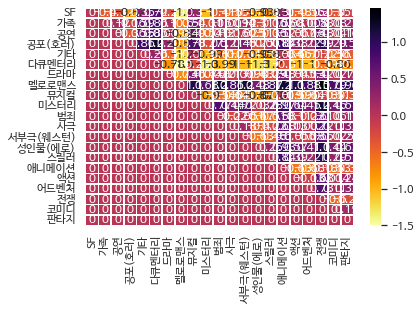

In [116]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumBarunGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='inferno_r', linewidths=.5
)
ax

----
\\

# 회고!




* 아이펠에서 정말 다양한 모델을 만들어보고, 결과값을 도출 해 봤지만.. 단어의 편향도 체크 해 볼 수 있다니 기술은 이만큼이나 발전했나! 라고 새삼 느꼈다. 일단 그런 사람만이 할 수 있을것이라 생각했던 부분 까지 수치로 계산해서, 컴퓨터가 분류 할 수 있게끔 만들었다는것 자체가 너무 신기했고, 점점 더 수학을 외면 할 수 없게되었다..... 😞

* tokenize를 만들 때, 각 하이퍼 파라미터에 대한 설명이 궁금해 찾아봤었는데, 위에 적용된 것들 말고도 다양한 하이퍼 파라미터들이 있었다. 적용해 볼 수 있는 하이퍼파라미터를 이용해 적용하면, 임베딩 모델의 성능이 나아졌을까? 성능이 좋았다면 분명 LMS에서 바꿔보라고 권하셨겠지만.. 딱히 권하시질 않은걸 보니 그렇게 큰 성능 변화는 없을.. 지도 모른다는 생각에 시도해 보진 않았다. 의문만 의문만.. 

* heatmap 시각화 할 때, 다른 색은 쓰고싶은데, 뭣도 모르고 파스텔 톤 하고싶다구 `pastel` 적어서 오류 메세지 띄워서 다른색으로 바꿔야 할 때, 또는 특정 파레트로 하고싶은데 무슨 느낌인지 모를때를 위해 사이트 하나 찾아뒀다. 색이라도 다양하게, 입맛대로 바꿀 수 있으면 그래프 그리기가 좀 더 수월하겠지..?   
[페이지는 이쪽!](https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f)

----
\\

# 🖇 참고 페이지 

## Word2Vec 관련 

- [Word2Vec 하이퍼 파라미터 설명](https://happygrammer.github.io/nlp/word2vec/)

- [Word2Vec document](https://radimrehurek.com/gensim/models/word2vec.html)


## 폰트 설치 

- [코랩 한글 깨짐 현상](https://wooono.tistory.com/357)